## Import tables to mysql from csv file

In [1]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('order_items.csv', 'order_items'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments')  # Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='Sqlrootpass12!@',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'C:/Users/risha/Desktop/Projects/Ecommerce/Target_Sales_Dataset'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing order_items.csv
NaN values before replacement:
order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state            

## Analysing data using SQL queries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import mysql.connector

db = mysql.connector.connect (
    host = 'localhost',
    username = "root",
    password = 'Sqlrootpass12!@',
    database = 'ecommerce'
)

cursor = db.cursor()


### List all unique cities where customers are located.

In [45]:
query = """select distinct customer_city from customers"""

cursor.execute(query)
data = cursor.fetchall()

df = pd.DataFrame(data, columns= ["City"])

df.head()

,City
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


### Count the number of orders placed in 2017.

In [6]:
query = """ select count(order_id) as No_of_orders from orders where year(order_purchase_timestamp) = 2017"""

cursor.execute(query)
data = cursor.fetchall()
"Total number of orders placed in 2017 are ",data[0][0]

('Total number of orders placed in 2017 are ', 45101)

### Find the total sales per category

In [14]:
query = """ select p.product_category, round(sum(pay.payment_value),2) as total_sales
from order_items o join products p
join payments pay
on p.product_id = o.product_id
and pay.order_id = o.order_id
group by p.product_category"""

cursor.execute(query)
data = cursor.fetchall()

data

[('perfumery', 506738.66),
 ('Furniture Decoration', 1430176.39),
 ('telephony', 486882.05),
 ('bed table bath', 1712553.67),
 ('automotive', 852294.33),
 ('computer accessories', 1585330.45),
 ('housewares', 1094758.13),
 ('babies', 539845.66),
 ('toys', 619037.69),
 ('Furniture office', 646826.49),
 ('Cool Stuff', 779698.0),
 ('HEALTH BEAUTY', 1657373.12),
 ('pet Shop', 311268.97),
 ('General Interest Books', 64694.76),
 ('stationary store', 317440.07),
 ('Watches present', 1429216.68),
 ('PCs', 279121.55),
 ('climatization', 91170.66),
 ('Construction Tools Construction', 241475.63),
 ('sport leisure', 1392127.56),
 ('Bags Accessories', 187151.29),
 ('electronics', 259857.1),
 ('Casa Construcao', 136645.29),
 ('Games consoles', 195480.38),
 ('Fashion Bags and Accessories', 218158.28),
 ('home appliances', 95532.27),
 ('Garden tools', 838280.75),
 ('Agro Industria e Comercio', 118730.61),
 (None, 252801.71),
 ('audio', 60324.62),
 ('technical books', 24915.44),
 ('Construction Tools 

In [12]:
df = pd.DataFrame(data, columns = ["Category", "Sales"])
df

,Category,Sales
0,perfumery,506738.66
1,Furniture Decoration,1430176.39
2,telephony,486882.05
3,bed table bath,1712553.67
4,automotive,852294.33
...,...,...
69,cds music dvds,1199.43
70,La Cuisine,2913.53
71,Fashion Children's Clothing,785.67
72,PC Gamer,2174.43


### Calculate the percentage of orders that were paid in installments.

In [18]:
query = """ select (sum(
	case when payment_installments > 1 then 1
    else 0 end ) ) / count(*) *100
 as orders_paid_in_installments from payments;
"""

cursor.execute(query)

data = cursor.fetchall()

"the percentage of orders that were paid in installments is", data[0][0]

('the percentage of orders that were paid in installments is',
 Decimal('49.4200'))

### Count the number of customers from each state.

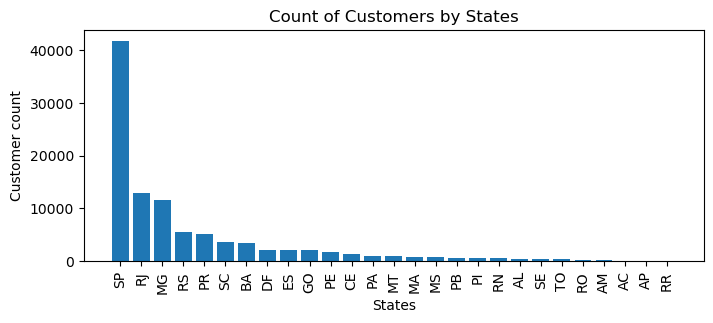

In [42]:
query = """ select customer_state, count(*) as No_of_customers from customers group by customer_state"""

cursor.execute(query)

data = cursor.fetchall()

df = pd.DataFrame(data, columns = ["state", "customer_count"])
df = df.sort_values(by = "customer_count", ascending = False)

plt.figure(figsize = (8,3))
plt.bar(df["state"], df["customer_count"])
plt.xlabel("States")
plt.ylabel("Customer count")
plt.title("Count of Customers by States")
plt.xticks(rotation = 90)
plt.show()

### Calculate the number of orders per month in 2018

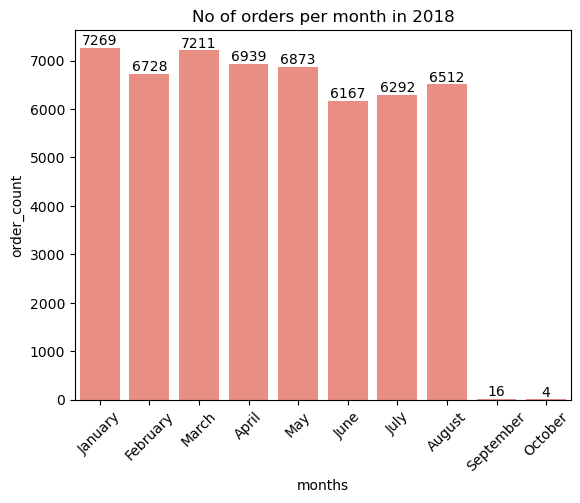

In [21]:
query = """ select monthname(order_purchase_timestamp) as Months , count(order_id) as No_of_orders from orders
where year(order_purchase_timestamp) = 2018
group by Months"""

cursor.execute(query)
data = cursor.fetchall()
df  = pd.DataFrame(data, columns = ["months","order_count"])

o = ["January", "February", "March", "April", "May","June","July","August","September","October"]
ax = sns.barplot(x = "months", y = "order_count",data = df, order = o, color = "salmon")
ax.bar_label(ax.containers[0])
plt.title("No of orders per month in 2018")
plt.xticks(rotation = 45)
plt.show()

### Find the average number of products per order, grouped by customer city

In [23]:
query = """ with order_count as (select order_items.order_id, orders.customer_id, count(order_items.order_item_id) as count_of_orders
from order_items join orders using(order_id)
group by order_items.order_id,orders.customer_id)

select customers.customer_city, round(avg(order_count.count_of_orders),2) as Avg_order
from customers join order_count
on customers.customer_id = order_count.customer_id
group by customers.customer_city
order by Avg_order desc"""

cursor.execute(query)
data = cursor.fetchall()

df = pd.DataFrame(data, columns = ["Customer City","Avg products/order"])
df.head()

,Customer City,Avg products/order
0,padre carvalho,7.00
1,celso ramos,6.50
2,candido godoi,6.00
3,datas,6.00
4,matias olimpio,5.00


### Calculate percentage of total revenue contributed by each product category

In [26]:
query = """ select p.product_category,
round((sum(pay.payment_value)/(select sum(payment_value) from payments))*100,2) as "pct_total_revenue"
from order_items o join products p
join payments pay
on p.product_id = o.product_id
and pay.order_id = o.order_id
group by p.product_category
order by pct_total_revenue desc"""

cursor.execute(query)
data = cursor.fetchall()

df = pd.DataFrame(data,columns = ["Category", "percentage distribution"])
df.head()

,Category,percentage distribution
0,bed table bath,10.70
1,HEALTH BEAUTY,10.35
2,computer accessories,9.90
3,Furniture Decoration,8.93
4,Watches present,8.93


### Identify the correlation between product price and the number of times a product has been purchased.

In [31]:
query = """select products.product_category, round(avg(order_items.price),2) avg_price, count(order_items.order_id) as purchase_count 
from order_items join products
using(product_id)
group by products.product_category"""

cursor.execute(query)
data = cursor.fetchall()

df = pd.DataFrame(data, columns = ["category","avg_price","purchase_count"])

arr1 = df["purchase_count"]
arr2 = df["avg_price"]

a = np.corrcoef([arr1,arr2])
print("the correlation is", a[0][1])

the correlation is -0.10631514167157562


### Calculate the total revenue generated by each seller, and rank them by revenue

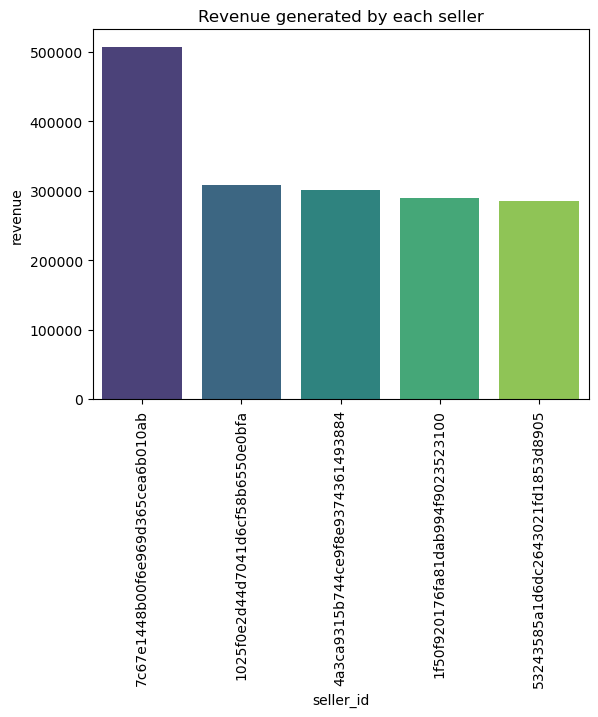

In [50]:
query = """select *, dense_rank() over(order by revenue desc) as ranks from ( 
select order_items.seller_id, round(sum(payments.payment_value),2) revenue
from order_items join payments on order_items.order_id = payments.order_id
group by seller_id) as A"""

cursor.execute(query)
data = cursor.fetchall()
df = pd.DataFrame(data, columns = ["seller_id","revenue","rank"])
sns.barplot(x="seller_id", y="revenue", data = df.head(), hue = df["seller_id"].head(), palette = "viridis")
plt.xticks(rotation = 90)
plt.title("Revenue generated by each seller")
plt.show()

### Calculate the moving average of order values for each customer over their order history

In [51]:
query = """select customer_id, order_purchase_timestamp, payment_value,
avg(payment_value) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg
 from 
(select orders.customer_id, orders.order_purchase_timestamp,payments.payment_value
from orders join payments
using(order_id)) as A"""
cursor.execute(query)
data = cursor.fetchall()
df = pd.DataFrame(data)
df

,0,1,2,3
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002
...,...,...,...,...
103881,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,71.23,27.120001
103882,fffeda5b6d849fbd39689bb92087f431,2018-05-22 13:36:02,63.13,63.130001
103883,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.13,214.130005
103884,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000


### Calculate the cumulative sales per month for each year

In [58]:
query = """select years, months , payment, sum(payment)
over(partition by years order by years, months) cumulative_sales from 
(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years, months order by years, months) as a
"""
cursor.execute(query)
data = cursor.fetchall()
df = pd.DataFrame(data, columns = ["year","month","payment","cumulative_sum"])
df

,year,month,payment,cumulative_sum
0,2016,9,252.24,252.24
1,2016,10,59090.48,59342.72
2,2016,12,19.62,59362.34
3,2017,1,138488.04,138488.04
4,2017,2,291908.01,430396.05
5,2017,3,449863.60,880259.65
6,2017,4,417788.03,1298047.68
7,2017,5,592918.82,1890966.50
8,2017,6,511276.38,2402242.88
9,2017,7,592382.92,2994625.80


### Calculate the year-over-year growth rate of total sales

In [59]:
query = """with yoy_sales as 
(select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years order by years)
select years,payment, lag(payment,1) over(order by years) prev_year_sales,
((payment - lag(payment,1) over(order by years)) / lag(payment,1) over(order by years) )* 100 "yoy_%_sales"
from yoy_sales
"""
cursor.execute(query)
data = cursor.fetchall()
df = pd.DataFrame(data, columns = ["year","payment","prev_year_sales","yoy_%_sales"])
df

,year,payment,prev_year_sales,yoy_%_sales
0,2016,59362.34,NaN,NaN
1,2017,7249746.73,59362.34,12112.703761
2,2018,8699763.05,7249746.73,20.000924


### Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase

In [61]:
query = """with a as (select customers.customer_id,
min(orders.order_purchase_timestamp) first_order
from customers join orders
on customers.customer_id = orders.customer_id
group by customers.customer_id),

b as (select a.customer_id, count(distinct orders.order_purchase_timestamp) next_order
from a join orders
on orders.customer_id = a.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < 
date_add(first_order, interval 6 month)
group by a.customer_id) 

select 100 * (count( distinct a.customer_id)/ count(distinct b.customer_id)) 
from a left join b 
on a.customer_id = b.customer_id """

cursor.execute(query)
data = cursor.fetchall()

data

[(None,)]

### Identify the top 3 customers who spent the most money in each year

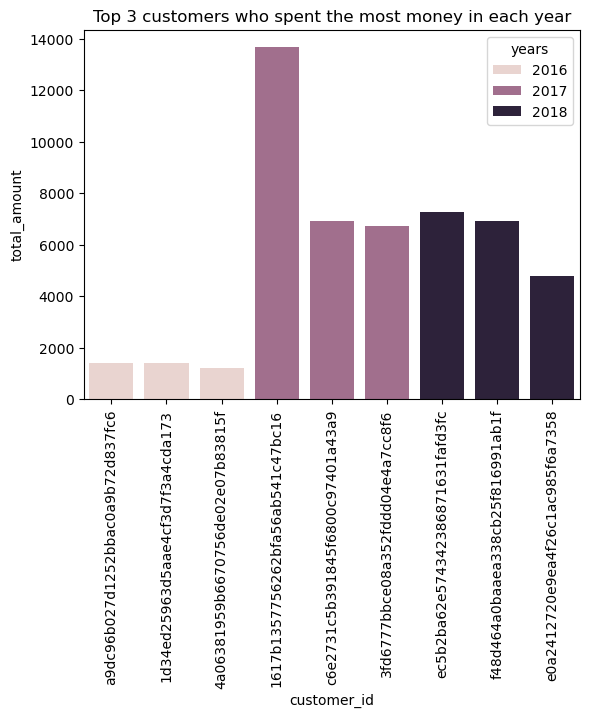

In [13]:
query = """ with rank_table as(
select customer_id, year(order_purchase_timestamp) as years, sum(payments.payment_value) as amount,
dense_rank() over(partition by year(order_purchase_timestamp) order by sum(payments.payment_value) desc) as ranks
from orders join payments using(order_id)
group by customer_id, years
order by years)

select * from rank_table where ranks<4 """

cursor.execute(query)
data = cursor.fetchall()

df = pd.DataFrame(data, columns = ["customer_id", "years", "total_amount","ranks"])
sns.barplot(x = "customer_id", y = "total_amount", data = df, hue = "years")
plt.title("Top 3 customers who spent the most money in each year")
plt.xticks(rotation=90)
plt.show()